In [3]:
%pylab inline
from astropy.table import Table
from pycheops.instrument import response
from scipy.interpolate import interp1d
from scipy.integrate import simps
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt

Populating the interactive namespace from numpy and matplotlib


g_GROND     :   482 +/-    35 nm,   0.0493+/-  0.0014 
r_GROND     :   626 +/-    34 nm,   0.0519+/-  0.0012 
i_GROND     :   764 +/-    36 nm,   0.0498+/-  0.0008 
z_GROND     :   900 +/-    52 nm,   0.0575+/-  0.0019 
g_PISCO     :   482 +/-    35 nm,   0.0565+/-  0.0013 
i_PISCO     :   764 +/-    36 nm,   0.0511+/-  0.0009 
J           :  1242 +/-    64 nm,   0.0457+/-  0.0058 
H           :  1648 +/-    76 nm,   0.0418+/-  0.0057 
K           :  2166 +/-    86 nm,   0.0610+/-  0.0075 
MEarth      :   842 +/-    79 nm,   0.0487+/-  0.0010 
CHEOPS      :   787 +/-   126 nm,   0.0494+/-  0.0021 
Spitzer     :  4443 +/-   284 nm,   0.0492+/-  0.0008 
LDSS3C      :   898 +/-    86 nm,   0.0490+/-  0.0010 
WFC3        :  1366 +/-   146 nm,   0.0495+/-  0.0010 
TESS        :   890 +/-   107 nm,   0.0481+/-  0.0010 


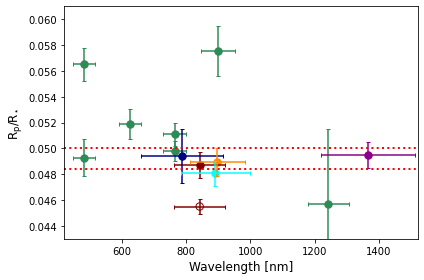

In [16]:
binning = 5
T = Table.read('lte031-5.0-0.0a+0.0.BT-Settl.dat',format='ascii.fast_basic',names=['w','logf'])
T.add_column(T['w']//int(binning),name='BIN')
T_b = T.group_by('BIN')
T = T_b.groups.aggregate(np.mean)
f1 = interp1d(T['w']/10, T['w']*10**T['logf'],bounds_error=False,fill_value=0)   # wave/nm, photon flux
T = Table.read('lte031-5.0-0.5a+0.2.BT-Settl.dat',format='ascii.fast_basic',names=['w','logf'])
T.add_column(T['w']//int(binning),name='BIN')
T_b = T.group_by('BIN')
T = T_b.groups.aggregate(np.mean)
f2 = interp1d(T['w']/10, T['w']*10**T['logf'],bounds_error=False,fill_value=0)   # wave/nm, photon flux

k = {}
# Data from Table 5 of Southworth 2017
r_A = 0.0775  # From Table 2 of Southworth 2017 
k['g_GROND'] = ufloat(0.00382, 0.00011)/r_A
k['r_GROND'] = ufloat(0.00402, 0.00009)/r_A
k['i_GROND'] = ufloat(0.00386, 0.00006)/r_A
k['z_GROND'] = ufloat(0.00446, 0.00015)/r_A
k['g_PISCO'] = ufloat(0.00438, 0.00010)/r_A
k['i_PISCO'] = ufloat(0.00396, 0.00007)/r_A
k['J'] = ufloat(0.00354, 0.00045)/r_A
k['H'] = ufloat(0.00324, 0.00044)/r_A
k['K'] = ufloat(0.00473, 0.00058)/r_A
# From my reanalysis
k['MEarth'] = ufloat(0.0487, 0.0010)
k['CHEOPS'] = ufloat(0.0494, 0.0021)
k['Spitzer'] = ufloat(0.0492, 0.0008)
k['LDSS3C'] = ufloat(0.04895, 0.00105)

LDSS3C = Table.read('Diamond-Lowe_Table6.csv')
Lw = np.array(LDSS3C['wave'])

# From Mugnai+2021 - average over visits in Mugnai_2021_depth.csv
k['WFC3'] = usqrt(ufloat(0.002449, 0.000098))
Ww = np.linspace(1.1262,1.6295)*1000

# From Mugnai+2021 - TESS
k['TESS'] = usqrt(ufloat(0.002312, 0.000093))
                
fig,ax = subplots()

for passband in (k.keys()):
    if passband is 'MEarth':
        R = response()
        wave = np.array(R['Wavelength'])
        resp = np.array(R['Response'])
        resp[wave < 715] = 0
    elif passband is 'Spitzer':
        T = Table.read('201125ch2trans_full.txt',format='ascii')
        wave = np.array(T['col1'])*1e3
        resp = np.array(T['col2'])
    elif passband in ['J','H','K']:
        T = Table.read(f'{passband}_2MASS.dat',format='ascii.fast_no_header')
        wave = np.array(T['col1'])/10
        resp = np.array(T['col2'])        
    elif passband is 'LDSS3C':
        wave = Lw
        resp = np.ones_like(wave) 
    elif passband is 'WFC3':
        wave = Ww
        resp = ones_like(wave)
    elif passband is 'TESS':
        T = Table.read('TESS.csv',format='ascii.no_header',delimiter=',')
        wave = np.array(T['col1'])
        resp = np.array(T['col2']) 
    elif passband is 'CHEOPS':
        R = response(passband=passband)
        wave = np.array(R['Wavelength'])
        resp = np.array(R['Response'])
    else:
        R = response(passband=passband[:2])
        wave = np.array(R['Wavelength'])
        resp = np.array(R['Response'])
    flux = 0.4*(f1(wave)) + 0.6*(f2(wave))
    flux = flux/nanmax(flux)

    phot = resp*flux
    phot = phot/simps(phot,wave)
    wbar = simps(phot*wave,wave)
    wrms = sqrt(simps(phot*wave**2,wave) - wbar**2)
    c = ('navy'  if passband is 'CHEOPS' 
         else 'darkorange' if passband is "LDSS3C" 
         else 'maroon' if passband is "MEarth" 
         else 'cyan' if passband is "TESS" 
         else 'darkmagenta' if passband is "WFC3" 
         else "seagreen")
#    if passband is 'WFC3':
#        ax.plot(Ww,Wk,c=c)
#        ax.errorbar(Ww,Wk,c=c,fmt='.',yerr=We,label='WFC3')
#    elif passband is 'LDSS3C':
#        ax.plot(Lw,Lk,c=c)
#        ax.scatter(Lw,Lk,c=c,s=3,label='LDSS3C')
#    else:
    ax.errorbar(wbar,k[passband].n,xerr=wrms,yerr=k[passband].s,c=c,capsize=2)
    ax.scatter([wbar],[k[passband].n],label=passband.replace('_',"'"),c=c, s=55)
    print(f'{passband:<12s}: {wbar:5.0f} +/- {wrms:5.0f} nm, {k[passband]:8.4f} ')
            
ax.axhline(0.0492+0.0008,c='r',ls=':',lw=2,label='Spitzer 4.5$\mu$m')
ax.axhline(0.0492-0.0008,c='r',ls=':',lw=2)
#axhline(0.0512+0.0025,c='g',ls='--',label='Berta-Thompson')
#axhline(0.0512-0.0025,c='g',ls='--')

# MEarth value from Dittman et al.
R = response()
wave = np.array(R['Wavelength'])
resp = np.array(R['Response'])
resp[wave < 715] = 0
flux = 0.4*(f1(wave)) + 0.6*(f2(wave))
flux = flux/nanmax(flux)
phot = resp*flux
phot = phot/simps(phot,wave)
wbar = simps(phot*wave,wave)
wrms = sqrt(simps(phot*wave**2,wave) - wbar**2)
c = 'maroon'   
ax.errorbar(wbar,0.0455,xerr=wrms,yerr=0.0006,c=c,capsize=2,ms=0)
ax.scatter([wbar],[0.0455],label=passband.replace('_',"'"),edgecolor=c,facecolor='none', s=55)

#legend(loc='lower left')
ax.set_xlim(420,1520)
ax.set_ylim(0.043,0.061)
ax.set_xlabel('Wavelength [nm]',fontsize=12)
ax.set_ylabel(r'R$_{\rm p}$/R$_{\star}$',fontsize=12)
fig.tight_layout()
fig.savefig('GJ_1132_k_wave.png')